## Import

In [6]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import numpy as np
import scipy.linalg as linalg
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
#import preprocess


device = 'cuda:7'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [ ]:
from distributions.MoG import MoG

n, d = 10000, 16                                 # num of samples; data dimensionality

mu = torch.zeros(d)                              
cov = torch.eye(d) 
rho = 0.7
for i in range(d//2):
    cov[i][i+d//2] = rho
    cov[i+d//2][i] = rho

dataset = MoG(n_samples=n, n_dims=d, 
                coeff_array = [0.2, 0.2, 0.1, 0.4, 0.1],
                mu_array = [mu + 2*i for i in range(5)],
                cov_array = [(0.1+i*0.2)*cov for i in range(5)],
            )

Z = dataset.sample_data(n_samples = n).clone().detach().to(device)
H = dataset.entropy()

print('data size', Z.size())
print('entropy', H)

data size torch.Size([10000, 16])
entropy 14.099194526672363


## Copula estimate

In [ ]:
from GC import GC

gc = GC()
gc.learn(Z)
log_probs = gc.log_probs(Z)

H_gc = -log_probs.mean().item()

print('H', H)
print('H_gc', H_gc)

H 14.080938339233398
H_gc 19.499267578125


## Visualizing marginals

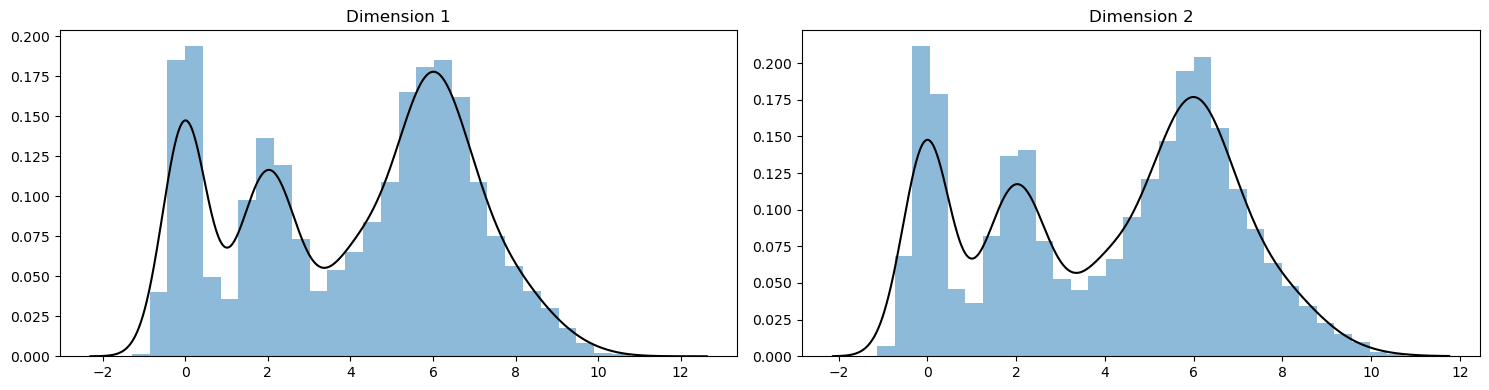

In [11]:
from scipy.stats import gaussian_kde



fig, axes = plt.subplots(1, 2, figsize=(15, 4))  # 1 row, 3 columns

for j in range(2):
    ax = axes[j]
    J = 0 + j*d//2

    x = Z[:, J].cpu().numpy()
    kde = gc.marginals[J]
    x_grid = np.linspace(np.min(x)-1, np.max(x)+1, 1000)
    kde_vals = kde.evaluate(x_grid)

    # Plot histogram
    ax.hist(x, bins=30, density=True, alpha=0.5, label='Histogram')
    
    # Plot KDE
    ax.plot(x_grid, kde_vals, label='KDE', color='black')
    
    ax.set_title(f"Dimension {j+1}")

plt.tight_layout()
plt.show()